In [2]:
import kaggle as kaggle
import pandas as pd 


#  Download the dataset from Kaggle
!kaggle datasets download -d ajinkyachintawar/sales-and-customer-behaviour-insights


Dataset URL: https://www.kaggle.com/datasets/ajinkyachintawar/sales-and-customer-behaviour-insights
License(s): CC0-1.0
sales-and-customer-behaviour-insights.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import glob
import matplotlib.dates as mdates

file_list = glob.glob('sales-and-customer-behaviour-insights/*.csv')
print(f"Found {len(file_list)} files: {file_list}")


# Load the dataset into a pandas DataFrame
dfs = [pd.read_csv(f) for f in file_list]

# Display the first few rows of each DataFrame
# print("Customer Info:")
# print(dfs[0].head())  
# print("\nProduct Info:")
# print(dfs[1].head())
# print("\nSales data:")
# print(dfs[2].head())

# Analysis sales per product
sales_data = dfs[2]
product_info = dfs[1]

product_merged = pd.merge(sales_data, product_info, on='product_id', how='left')
# print(product_merged)

product_sales_count = product_merged['product_id'].value_counts().reset_index()
# print("Sales Count per Product:")
# print(product_sales_count.head())

# Analysis total sales per product
product_merged['quantity'] = pd.to_numeric(product_merged['quantity'], errors='coerce').fillna(0)

product_sales = product_merged.groupby('product_id')["quantity"].sum().reset_index()
product_sales = product_sales.sort_values(by='quantity', ascending=False)
# print("Total Sales per Product:")
# print(product_sales.head())

#  Average sold per product
average_sales = product_merged.groupby('product_id')["quantity"].mean().reset_index()
average_sales = average_sales.sort_values(by='quantity', ascending=False)
print("Average Sales per Product:")
print(average_sales.head())

average_total_sales = pd.merge(average_sales, product_sales, on='product_id', how='left', suffixes=('_average', '_total'))
sales_stats = pd.merge(average_total_sales, product_sales_count, on='product_id', how='left')
print("Average and Total Sales per Product:")
print(sales_stats.head())


# Sales der Produkte nach Launch Datum
product_info['launch_date'] = pd.to_datetime(product_info['launch_date'], errors='coerce')
product_merged = pd.merge(sales_stats, product_info, on='product_id', how='left')

product_merged['date_numeric'] = mdates.date2num(product_merged['launch_date'])

print("Sales Data with Launch Dates:")
print(product_merged[["product_id", "quantity_total", "count", "launch_date", "date_numeric"]].head())

Found 3 files: ['sales-and-customer-behaviour-insights\\customer_info.csv', 'sales-and-customer-behaviour-insights\\product_info.csv', 'sales-and-customer-behaviour-insights\\sales_data.csv']
Average Sales per Product:
   product_id  quantity
23      P0024  3.252747
14      P0015  3.250000
13      P0014  3.227273
18      P0019  3.219780
3       P0004  3.204082
Average and Total Sales per Product:
  product_id  quantity_average  quantity_total  count
0      P0024          3.252747           296.0     91
1      P0015          3.250000           351.0    108
2      P0014          3.227273           355.0    110
3      P0019          3.219780           293.0     91
4      P0004          3.204082           314.0     98
Sales Data with Launch Dates:
  product_id  quantity_total  count launch_date  date_numeric
0      P0024           296.0     91  2025-02-24       20143.0
1      P0015           351.0    108  2024-08-08       19943.0
2      P0014           355.0    110  2025-02-02       20121.

C:\Users\paula\AppData\Local\Temp\ipykernel_7532\1836490292.py:51: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  product_info['launch_date'] = pd.to_datetime(product_info['launch_date'], errors='coerce')


In [4]:
import scipy.stats as stats

# Regression analysis
slope, intercept, r_value_launch_date, p_value_launch_date, std_err = stats.linregress(product_merged['date_numeric'], product_merged['quantity_total'])
print(f"Regression Launchdate: r2= {r_value_launch_date**2:.4f}, p-value= {p_value_launch_date:.4f}")

slope, intercept, r_value_qty_avg, p_value_qty_avg, std_err = stats.linregress(sales_stats['quantity_average'], sales_stats['count'])
print(f"Regression Quantity Average: r2= {r_value_qty_avg**2:.4f}, p-value= {p_value_qty_avg:.4f}")

slope, intercept, r_value_qty_total, p_value_qty_total, std_err = stats.linregress(sales_stats['quantity_total'], sales_stats['count'])
print(f"Regression Quantity Total: r2= {r_value_qty_total**2:.4f}, p-value= {p_value_qty_total:.4f}")

Regression Launchdate: r2= 0.0361, p-value= 0.3148
Regression Quantity Average: r2= 0.0026, p-value= 0.7897
Regression Quantity Total: r2= 0.7461, p-value= 0.0000


C:\Users\paula\AppData\Local\Temp\ipykernel_7532\1765433045.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
C:\Users\paula\AppData\Local\Temp\ipykernel_7532\1765433045.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45)


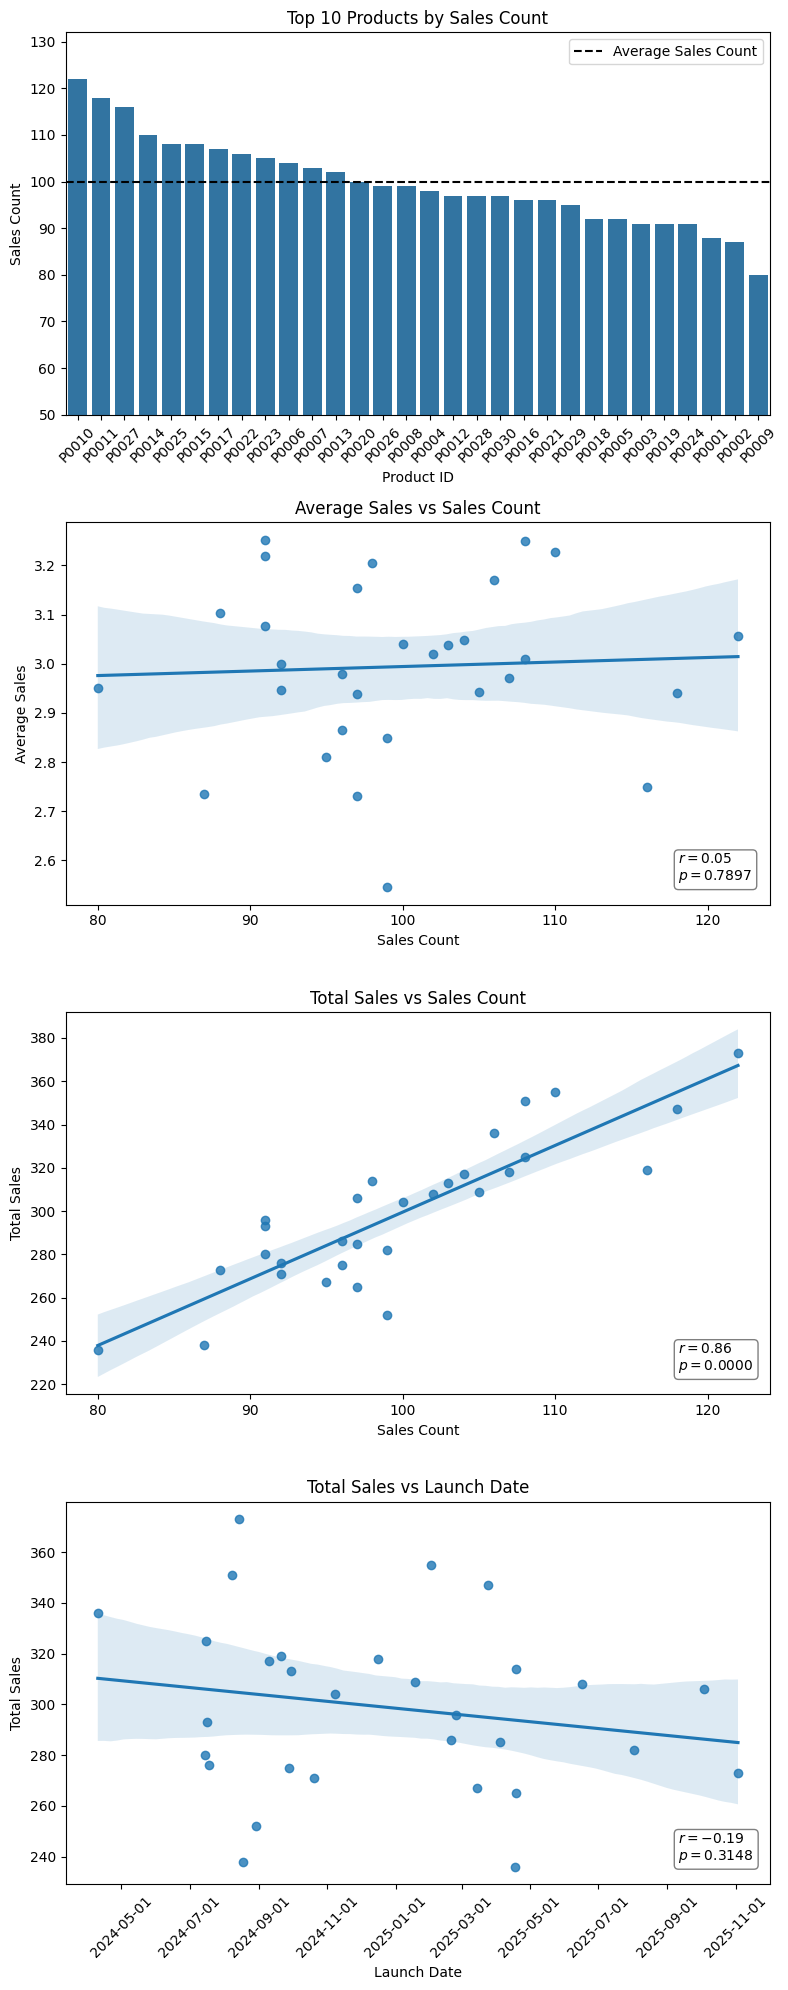

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


# Visualize sales per product

fig, ax = plt.subplots(4, 1, figsize=(8, 20))

#  Top 10 products by sales count
sns.barplot(data=product_sales_count, x="product_id", y="count", ax=ax[0])
ax[0].set_title('Top 10 Products by Sales Count')
ax[0].set_xlabel('Product ID')
ax[0].set_ylabel('Sales Count')
ax[0].set_ylim(50, product_sales_count['count'].max() + 10)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].axhline(y=product_sales_count['count'].mean(), color='black', linestyle='--', label='Average Sales Count')
ax[0].legend()

#  Regression plots (Quantity Average and Quantity Total vs Sales Count)
sns.regplot(data=sales_stats, x="count", y="quantity_average", ax=ax[1])
ax[1].set_title('Average Sales vs Sales Count')
ax[1].set_xlabel('Sales Count')
ax[1].set_ylabel('Average Sales')
stats_text_qty_avg = f"$r = {r_value_qty_avg:.2f}$\n$p = {p_value_qty_avg:.4f}$"
ax[1].text(0.87, 0.05, stats_text_qty_avg, transform=ax[1].transAxes, 
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

sns.regplot(data=sales_stats, x="count", y="quantity_total", ax=ax[2])
ax[2].set_title('Total Sales vs Sales Count')
ax[2].set_xlabel('Sales Count') 
ax[2].set_ylabel('Total Sales')
stats_text_qty_total = f"$r = {r_value_qty_total:.2f}$\n$p = {p_value_qty_total:.4f}$"
ax[2].text(0.87, 0.05, stats_text_qty_total, transform=ax[2].transAxes, 
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


#  Regression plot (Launch Date vs Quantity Total)
sns.regplot(data=product_merged, x="date_numeric", y="quantity_total", ax=ax[3])
ax[3].set_title('Total Sales vs Launch Date')
ax[3].set_xlabel('Launch Date')
ax[3].set_ylabel('Total Sales')
ax[3].xaxis_date()
date_format = mdates.DateFormatter('%Y-%m-%d')
ax[3].xaxis.set_major_formatter(date_format)
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45)
stats_text_launch_date = f"$r = {r_value_launch_date:.2f}$\n$p = {p_value_launch_date:.4f}$"
ax[3].text(0.87, 0.05, stats_text_launch_date, transform=ax[3].transAxes, 
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


plt.tight_layout()
plt.show()

Total unique customers: 499
Average Purchases per Customer: 6.01
Median Purchases per Customer: 6.0
     customer_id  quantity  unit_price  total_amount payment_method
0         C00397       3.0       39.25        117.75         paypal
1         C00236       5.0       18.92         94.60    credit card
2         C00492       1.0       29.68         29.68  bank transfer
3         C00031       1.0       32.76         32.76    credit card
4         C00495       1.0       47.62         47.62    credit card
...          ...       ...         ...           ...            ...
2995      C00233       5.0       43.40        217.00  bank transfer
2996      C00246       4.0       34.04        136.16  bank transfer
2997      C00182       1.0       42.34         42.34    credit card
2998      C00074       5.0       35.96        179.80    credit card
2999      C00405       3.0       43.23        129.69    credit card

[3000 rows x 5 columns]


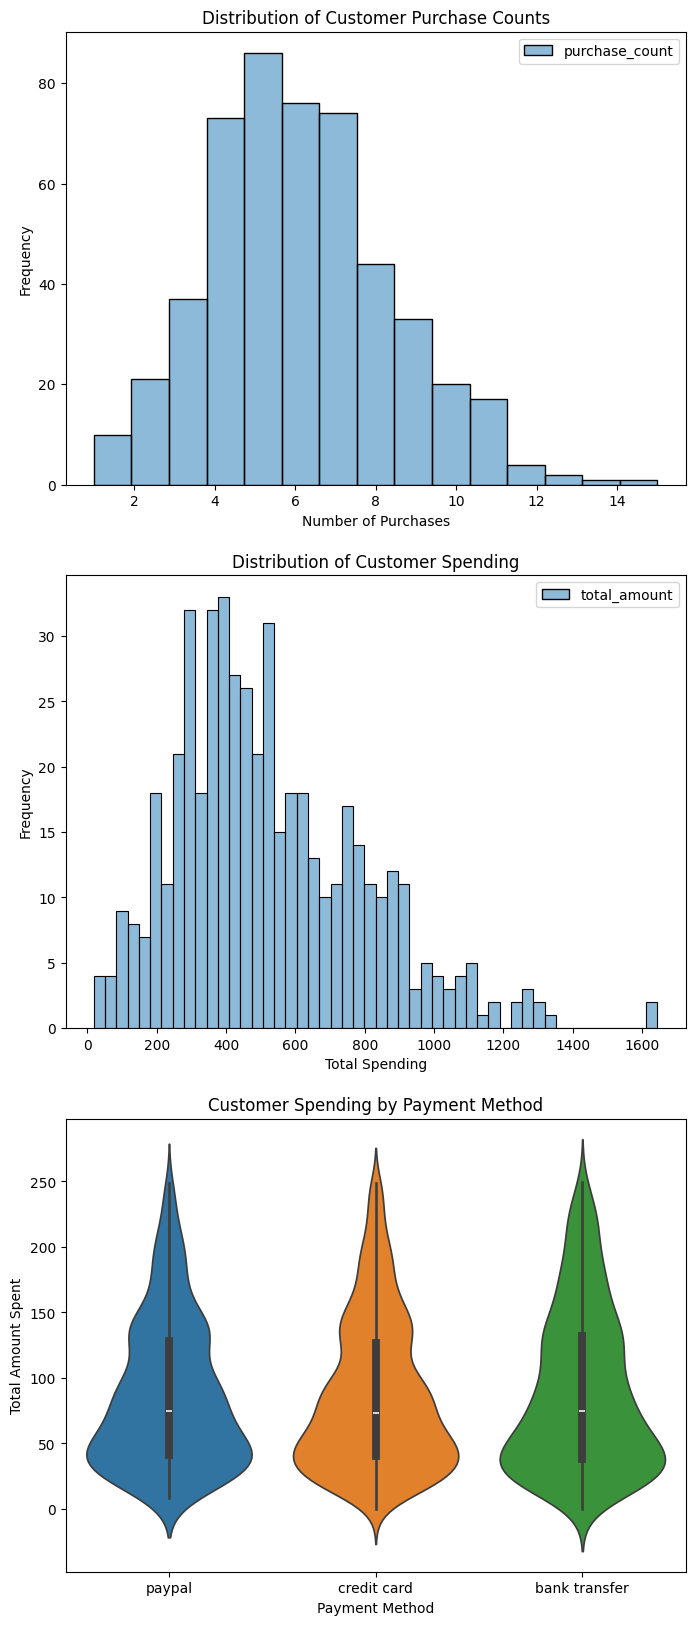

In [62]:
# Customer spending and payment method analysis

import numpy as np

#  Unique customers und Anzahl der Einkäufe pro Kunde
customer_count = dfs[2]['customer_id'].nunique()
print(f"Total unique customers: {customer_count}")

customer_grouped_purchase_counts = dfs[2].groupby('customer_id').size().reset_index(name='purchase_count')

# print("Customer Purchase Counts:")
# print(customer_grouped_purchase_counts)

# Durchnschnitt und Median der Einkäufe pro Kunde
customer_avg_purchases = np.mean(customer_grouped_purchase_counts["purchase_count"])
print(f"Average Purchases per Customer: {customer_avg_purchases:.2f}")

customer_median_purchases = np.median(customer_grouped_purchase_counts["purchase_count"])
print(f"Median Purchases per Customer: {customer_median_purchases}")

purchase_size_count = customer_grouped_purchase_counts["purchase_count"].nunique()

#  Ausgaben pro Kunde

dfs[2]['quantity'] = pd.to_numeric(dfs[2]['quantity'], errors='coerce').fillna(0)
dfs[2]["total_amount"] = pd.to_numeric(dfs[2]['quantity'], errors='coerce') * pd.to_numeric(dfs[2]['unit_price'], errors='coerce')

print(dfs[2][["customer_id", "quantity", "unit_price", "total_amount", "payment_method"]])
dfs[2]['payment_method'] = dfs[2]['payment_method'].str.strip().str.lower()

typo_check = dfs[2]['payment_method'].str.strip().str.lower().value_counts()
# print(typo_check)

corrections = {
    'bank transfr': 'bank transfer'
}

dfs[2]['payment_method'] = dfs[2]['payment_method'].replace(corrections, regex=True)

customer_spending = dfs[2].groupby('customer_id')["total_amount"].sum().reset_index()

top_customer_spending = customer_spending.sort_values(by='total_amount', ascending=False).head(10)
# print("Top 10 Customers by Spending:")
# print(top_customer_spending)  


# print("Customer Spending:")
# print(customer_spending.head())


#  Visualisierung der Verteilung der Einkäufe pro Kunde
fig, ax = plt.subplots(3, 1,figsize=(8, 20))

sns.histplot(customer_grouped_purchase_counts, bins=purchase_size_count, kde=False, ax=ax[0])
ax[0].set_title('Distribution of Customer Purchase Counts')
ax[0].set_xlabel('Number of Purchases')
ax[0].set_ylabel('Frequency')

sns.histplot(customer_spending, bins=50, kde=False, ax=ax[1])
ax[1].set_title('Distribution of Customer Spending')
ax[1].set_xlabel('Total Spending')
ax[1].set_ylabel('Frequency')

sns.violinplot(x='payment_method', y='total_amount', data=dfs[2], ax=ax[2], hue='payment_method')
ax[2].set_title('Customer Spending by Payment Method')
ax[2].set_xlabel('Payment Method')
ax[2].set_ylabel('Total Amount Spent')
ax[2].legend_.remove()

plt.show()
